In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
import torchvision
import cv2

from tqdm.notebook import tqdm

In [3]:
from functools import partial

In [4]:
from torch import nn

In [5]:
device = 'cuda:3'

In [6]:
env = gym.make('MontezumaRevengeDeterministic-v4', render_mode='rgb_array')
obs = env.reset()
# obs = torch.from_numpy(obs)

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


In [272]:
def to_latent(snapshot, obs, h=11, w=8, d=20, return_tuple=False):
    obs, _, _, _, _ = snapshot
    # obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    obs = cv2.resize(obs, (w, h), interpolation=cv2.INTER_AREA)
    obs = (obs/255.*d).astype(np.uint8)
    if return_tuple:
        return tuple(obs.flatten())
    else:
        return obs

class GoExploreAtariWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.n_lives = 6
        
    def reset(self, snapshot=None):
        if snapshot is None:
            obs, reward, done, info = self.env.reset(), 0, False, {}
            done = env.unwrapped.ale.lives() < self.n_lives
            if done:
                obs = np.zeros_like(obs)
            ale_state = self.env.ale.cloneState()
        else:
            (obs, reward, done, info, ale_state) = snapshot
            self.env.ale.restoreState(ale_state)
        snapshot = (obs, reward, done, info, ale_state)
        obs, reward, done = torch.as_tensor(obs)/255., torch.as_tensor(reward), torch.as_tensor(done)
        return snapshot, obs, reward, done, info
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        done = env.unwrapped.ale.lives() < self.n_lives
        if done:
            obs = np.zeros_like(obs)
        ale_state = self.env.ale.cloneState()
        snapshot = (obs, reward, done, info, ale_state)
        obs, reward, done = torch.as_tensor(obs)/255., torch.as_tensor(reward), torch.as_tensor(done)
        return snapshot, obs, reward, done, info

env = gym.make('MontezumaRevengeDeterministic-v4', render_mode='rgb_array')
env = gym.wrappers.GrayScaleObservation(env)
# env = gym.wrappers.ResizeObservation(env, (20, 20))
env = GoExploreAtariWrapper(env)
snapshot, obs, reward, done, info = env.reset()

In [273]:
# for i in range(20):
#     snapshot, obs, reward, done, info = env.step(4)
#     print(info['lives'], env.unwrapped.ale.lives())

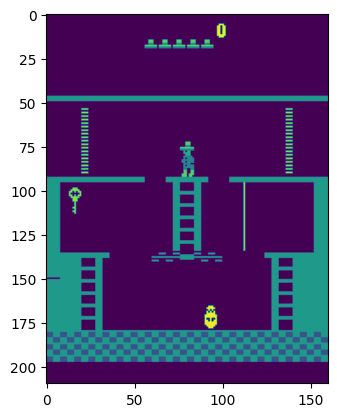

In [274]:
plt.imshow(obs)

In [275]:
np.random.seed(0)
snapshot, obs, reward, done, info = env.reset()
for i in range(10):
    snapshot, obs, reward, done, info = env.step(env.action_space.sample())

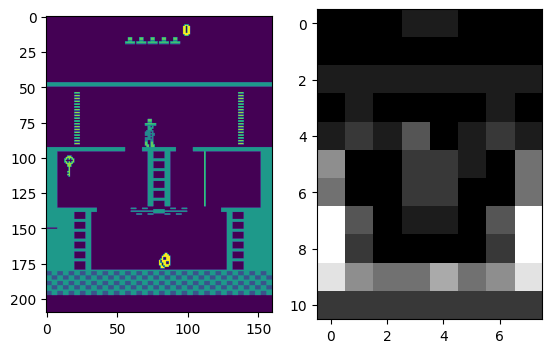

In [276]:
plt.subplot(121)
plt.imshow(obs)
plt.subplot(122)
plt.imshow(to_latent(snapshot, obs), cmap='gray')

In [376]:
class RandomExplorer(nn.Module):
    def __init__(self):
        super().__init__()
        
    def get_action_and_value(self, x, action=None):
        obs_ndim = len(env.observation_space.shape)
        bs = x.shape[:-obs_ndim]
        logits = torch.zeros(*bs, env.action_space.n)
        probs = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), 0.

In [390]:
from collections import defaultdict
class Node():
    def __init__(self, parent, traj, snapshot, obs, latent):
        self.parent = parent
        self.children = []
        
        self.traj = traj
        self.traj_len = len(traj) + (self.parent.traj_len if self.parent else 0)

        self.snapshot = snapshot
        self.obs = obs
        self.latent = latent
        
    def get_full_trajectory(self):
        if self.parent is None:
            return self.traj
        return self.parent.get_full_trajectory() + self.traj

class Archive(list):
    def __init__(self, node_root):
        self.node_root = node_root
        self.cell2node = {}
        self.cell2n_seen = defaultdict(lambda : 0)
        
        self.add_node(node_root)
        
    def add_node(self, node):
        self.cell2node[node.latent] = node
        # self.append(node)
        if node.parent:
            node.parent.children.append(node)
            
    def add_if_better(self, node):
        cells = set(self.cell2node.keys())
        if node.latent in cells:
            node_old = self.cell2node[node.latent]
            # if len(node.get_full_trajectory())<len(node_old.get_full_trajectory()):
            if node.traj_len < node_old.traj_len:
                for child in node_old.children: # don't accumulate other nodes
                    child.parent = 'dead'
                
                self.add_node(node)
                return 1 # better
            return 2 # worse
        else:
            self.add_node(node)
            return 0 # novel
        
class GoExplore():
    def __init__(self, env, explorer, to_latent):
        self.env = env
        self.explorer = explorer
        self.to_latent = to_latent
        
        snapshot, obs, reward, done, info = self.env.reset()
        latent = self.to_latent(snapshot, obs)
        node_root = Node(None, [], snapshot, obs, latent)
        self.archive = Archive(node_root)
        
        self.trajs_good = []
        self.trajs_bad = []

    def select_nodes(self, n):
        cells = list(self.archive.cell2node.keys())
        n_seen = np.array([self.archive.cell2n_seen[cell] for cell in cells])
        p = 1./np.sqrt(n_seen+1)
        p = p/p.sum()
        cells_select = [cells[i] for i in np.random.choice(len(cells), size=n, p=p)]
        return [self.archive.cell2node[cell] for cell in cells_select]

    def explore_from(self, node_start, len_traj):
        traj = [] # list of tuples (snapshot, obs, action, log_prob, reward)
        snapshot, obs, reward, done, info = env.reset(node_start.snapshot)
        # latents = set()
        for i_trans in range(len_traj):
            # latent = self.to_latent(snapshot, obs)
            # latents.add(latent)
            with torch.no_grad():
                action, log_prob, _, _ = self.explorer.get_action_and_value(obs.to(device))
                action, log_prob = action.cpu(), log_prob.cpu()
            snapshot_next, obs_next, reward, done, info = self.env.step(action.item())
            traj.append((snapshot, obs, done, action, log_prob, reward))
            snapshot, obs = snapshot_next, obs_next
        # latent = self.to_latent(snapshot, obs)
        # latents.add(latent)
        # return Node(node_start, traj, snapshot, obs, latent), latents, done
        return traj
    
    def step_explore(self, n_trajs, len_traj):
        # nodes = []
        # dones = []
        nodes_start = self.select_nodes(n_trajs)
        trajs = [self.explore_from(node, len_traj) for node in nodes_start]
        # n_trajs, len_traj, (snapshot, obs, done, action, log_prob, reward)
        
        for node_start, traj in zip(nodes_start, trajs):
            snapshot, obs, done, action, log_prob, reward = traj[-1]
            is_novel = self.to_latent(snapshot, obs) not in self.archive.cell2node
            
            parent = node_start
            for i_trans, (snapshot, obs, done, action, log_prob, reward) in enumerate(traj):
                latent = self.to_latent(snapshot, obs)
                node_end = Node(parent, traj[i_trans: i_trans+1], snapshot, obs, latent)
                parent = node_end
                
                self.archive.cell2n_seen[latent] += 1
                self.archive.add_if_better(node_end)
            
            if is_novel:
                self.trajs_good.append(traj)
            else:
                self.trajs_bad.append(traj)

In [391]:
explorer = RandomExplorer()
ge = GoExplore(env, explorer, to_latent=partial(to_latent, return_tuple=True))

In [407]:
for i in tqdm(range(200)):
    ge.step_explore(10, 10);

  0%|          | 0/200 [00:00<?, ?it/s]

In [458]:
len(ge.trajs_good), len(ge.trajs_bad)

(191, 2309)

torch.Size([439, 210, 160])
torch.Size([210, 160])


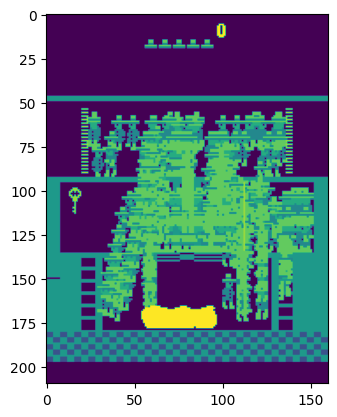

In [403]:
o = torch.stack([node.obs for node in ge.archive.cell2node.values()])
print(o.shape)
o = o.max(dim=0).values
# o = o.mean(dim=-1).mean(dim=0)
print(o.shape)
plt.imshow(o.numpy())

In [492]:
import nle

In [493]:
nle

<module 'nle' from '/afs/csail.mit.edu/u/a/akumar01/miniconda3/lib/python3.9/site-packages/nle/__init__.py'>

In [494]:
nle

<module 'nle' from '/afs/csail.mit.edu/u/a/akumar01/miniconda3/lib/python3.9/site-packages/nle/__init__.py'>

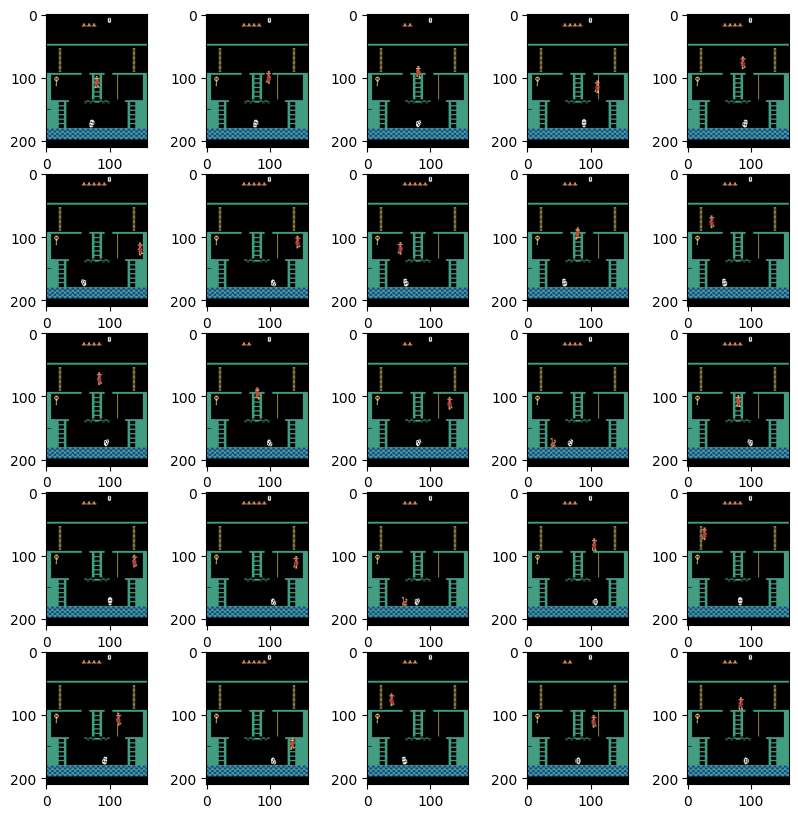

In [560]:
x, y = 5, 5
fig, axs = plt.subplots(x, y, figsize=(10, 10))
nodes = np.random.choice(ge.archive, size=(x, y))

for i in range(x):
    for j in range(y):
        axs[i, j].imshow(nodes[i, j].obs.numpy())

In [561]:
len(ge.archive)

1824

In [562]:
n = [ge.archive.cell2n_seen[node.latent] for node in ge.archive]

(array([784., 487., 263., 147.,  58.,  44.,  20.,  11.,   6.,   4.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <BarContainer object of 10 artists>)

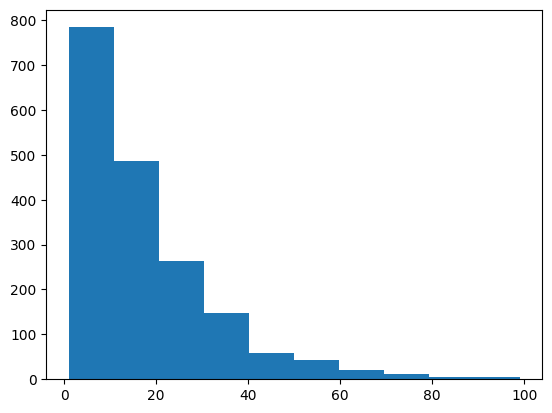

In [563]:
plt.hist(n)

In [564]:
o = np.stack([node.obs for node in ge.archive])
print(o.shape)
o = o[:, 97:120, 10:25]

(1824, 210, 160, 3)


In [565]:
o.std(axis=0).max()

1.1563287e-05

In [568]:
np.linalg.norm((o-o.mean(axis=0)).reshape(-1, 23*15*3), axis=-1).max()

9.62544e-05

In [491]:
def tensor_stack(a):
    if isinstance(a, torch.Tensor):
        return a
    elif isinstance(a, list):
        return torch.stack([tensor_stack(i) for i in a])
    
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer
    
class ImitationExplorer(nn.Module):
    def __init__(self):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(12, 10)),
            nn.Tanh(),
            layer_init(nn.Linear(10, 10)),
            nn.Tanh(),
            layer_init(nn.Linear(10, 1), std=1.0),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(12, 10)),
            nn.Tanh(),
            layer_init(nn.Linear(10, 10)),
            nn.Tanh(),
            layer_init(nn.Linear(10, 4), std=0.01),
        )
        self.opt = torch.optim.Adam(self.parameters(), lr=1e-4)
        self.losses_all = []

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        probs = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(x)
    
    def update_policy(self, ge, n_steps, batch_size, viz=False):
        obs_good = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_good])
        actions_good = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_good])
        obs_good = obs_good.reshape(-1, obs_good.shape[-1])
        actions_good = actions_good.reshape(-1)

        obs_bad = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_bad])
        actions_bad = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_bad])
        obs_bad = obs_bad.reshape(-1, obs_bad.shape[-1])
        actions_bad = actions_bad.reshape(-1)

        losses = []
        for i_batch in range(n_steps):
            idx_good = torch.randperm(len(obs_good))[:batch_size//2]
            idx_bad = torch.randperm(len(obs_bad))[:batch_size//2]
            batch_obs_good = obs_good[idx_good].to(device)
            batch_obs_bad = obs_bad[idx_bad].to(device)
            batch_actions_good = actions_good[idx_good].to(device)
            batch_actions_bad = actions_bad[idx_bad].to(device)

            _, log_probs_good, entropy, _ = self.get_action_and_value(batch_obs_good, batch_actions_good)
            _, log_probs_bad, entropy, _ = self.get_action_and_value(batch_obs_bad, batch_actions_bad)

            loss = log_probs_bad.mean()-log_probs_good.mean()

            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            losses.append(loss.item())

        batch_actions = torch.cat([batch_actions_good, batch_actions_bad], dim=0)
        log_probs = torch.cat([log_probs_good, log_probs_bad], dim=0)

        self.losses_all.extend(losses)
        if viz:
            plt.plot(losses)
            plt.show()
            for i in range(4):
                print(f'Action {i}')
                print(log_probs[batch_actions==i].mean().item())

class ImitationExplorer(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(1, 32, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=2)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 5 * 3, 512)),
            # layer_init(nn.Linear(64 * 7 * 7, 512)),
            nn.ReLU(),
        )
        self.actor = layer_init(nn.Linear(512, env.action_space.n), std=0.01)
        self.critic = layer_init(nn.Linear(512, 1), std=1)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.losses_all = []

    def get_value(self, x):
        return self.critic(self.network(x))

    def get_action_and_value(self, x, action=None):
        x = x[..., None, :, :]
        hidden = self.network(x)
        logits = self.actor(hidden)
        probs = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)
    
    def update_policy(self, ge, n_steps, batch_size, viz=False):
        print('a')
        obs_good = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_good])
        actions_good = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_good])
        print('b')
        obs_good = obs_good.reshape(-1, *obs_good.shape[2:])
        actions_good = actions_good.reshape(-1)
        print('c')

        obs_bad = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_bad])
        actions_bad = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_bad])
        print('d')
        obs_bad = obs_bad.reshape(-1, *obs_bad.shape[2:])
        actions_bad = actions_bad.reshape(-1)

        losses = []
        print('here')
        # plt.subplot(121)
        # plt.hist(actions_good.flatten().numpy())
        # plt.subplot(122)
        # plt.hist(actions_bad.flatten().numpy())
        # plt.show()
        
        for i_batch in tqdm(range(n_steps)):
            idx_good = torch.randperm(len(obs_good))[:batch_size//2]
            idx_bad = torch.randperm(len(obs_bad))[:batch_size//2]
            batch_obs_good = obs_good[idx_good].to(device)
            batch_obs_bad = obs_bad[idx_bad].to(device)
            batch_actions_good = actions_good[idx_good].to(device)
            batch_actions_bad = actions_bad[idx_bad].to(device)
            
            _, log_probs_good, entropy, _ = self.get_action_and_value(batch_obs_good, batch_actions_good)
            _, log_probs_bad, entropy, _ = self.get_action_and_value(batch_obs_bad, batch_actions_bad)
            # print(len(log_probs_good), len(log_probs_bad))

            loss = log_probs_bad.mean()-log_probs_good.mean()

            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            # losses.append(loss.item())
            losses.append(log_probs_good.mean().item())

        batch_actions = torch.cat([batch_actions_good, batch_actions_bad], dim=0)
        log_probs = torch.cat([log_probs_good, log_probs_bad], dim=0)

        self.losses_all.extend(losses)
        if viz:
            plt.plot(losses)
            plt.show()
            # for i in range(4):
                # print(f'Action {i}')
                # print(log_probs[batch_actions==i].mean().item())


In [489]:
net = ImitationExplorer(env).to(device)

# net.get_action_and_value(obs[None])
np.sum([p.numel() for p in net.parameters()])

610547

a
b
c
d
here


  0%|          | 0/50 [00:00<?, ?it/s]

500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500
500 500


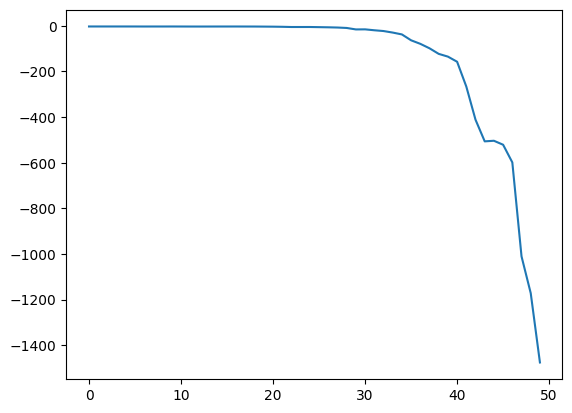

In [490]:
net.update_policy(ge, 50, 1000, viz=True)

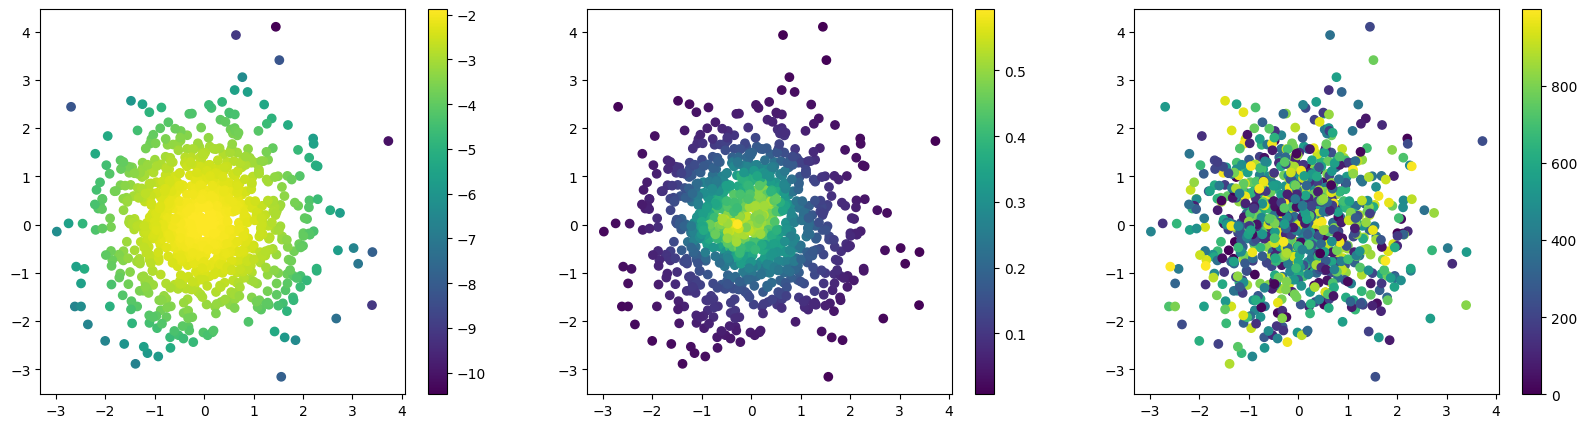

In [116]:
import sklearn.mixture

def gaussian_density(q):
    gm = sklearn.mixture.GaussianMixture(n_components=1)
    gm = gm.fit(x.numpy())
    return torch.from_numpy(gm.score_samples(q.numpy()))

def other_density(q):
    n, d = x.shape
    k = int(2.*(n**(1./d)))
    dist = (q[:, None]-x[None, :]).norm(dim=-1)
    dist = dist.sort(dim=-1).values[:, k]
    idist = dist**-d
    density = k/n*idist
    return density
def other_density2(q, p=.1):
    density = other_density(q)
    ranks = density.argsort()
    return ranks
    # density = p*(1.-p)**ranks
    # density = density/density.sum()
    # return density

torch.manual_seed(0)
x = torch.randn(1000, 2)


plt.figure(figsize=(20, 5))
plt.subplot(131)
d = gaussian_density(x)
plt.scatter(*x.numpy().T, c=d.numpy())
plt.colorbar()
plt.subplot(132)
d = other_density(x)
plt.scatter(*x.numpy().T, c=d.numpy())
plt.colorbar()
plt.subplot(133)
d = other_density2(x, p=0.001)
plt.scatter(*x.numpy().T, c=d.numpy())
plt.colorbar()

plt.show()